In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder, StarNetEncoder
from dataset_lib import CenteredStarsData, trim_psf
import optimization_lib

from which_device import device


_ = torch.manual_seed(34)
print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, slen)

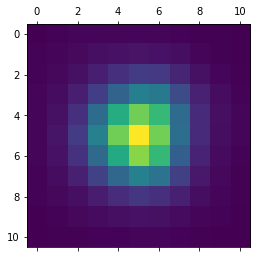

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [5]:
n_images = 10000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

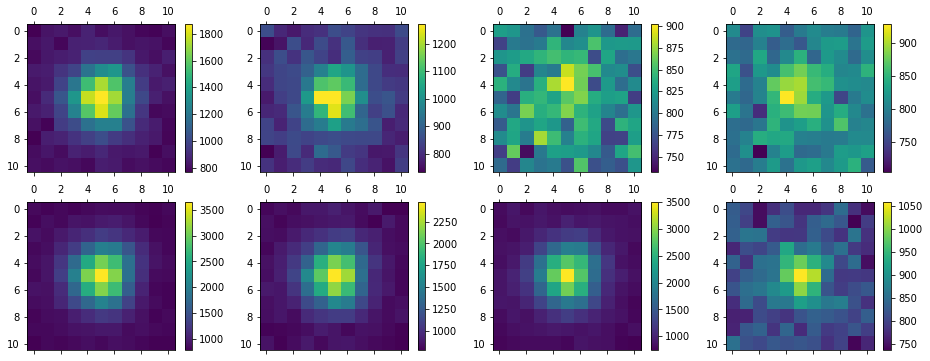

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(16, 6))

for i in range(8): 
        
    x0 = i // 4
    x1 = i % 4
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [7]:
network = MLPEncoder(slen = slen).to(device)
network

# network = StarNetEncoder(slen = slen).to(device)

MLPEncoder(
  (fc1): Linear(in_features=121, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

# Define dataset

In [8]:
batch_size = 128
train_data = DataLoader(star_data, 
                         batch_size=batch_size)


test_data = DataLoader(star_data, 
                       batch_size=n_images)

In [9]:
for _, test_batch in enumerate(test_data):
    break
    
network(test_batch['image'])

(tensor([250.4740, 281.1977, 258.2357,  ..., 256.2841, 260.1544, 247.8894],
        device='cuda:4', grad_fn=<SelectBackward>),
 tensor([7.6395e-01, 1.0000e-06, 2.8427e+01,  ..., 1.0000e-06, 2.6090e+01,
         2.9105e+01], device='cuda:4', grad_fn=<AddBackward0>))

# Choose the loss function

In [10]:
# loss_fun = optimization_lib.l2_loss

_loss_fun = optimization_lib.klqp
loss_fun = lambda net, batch : _loss_fun(net, batch, star_data.psf, star_data.background)

In [11]:
import inspect
lines = inspect.getsource(loss_fun)
print(lines)

loss_fun = lambda net, batch : _loss_fun(net, batch, star_data.psf, star_data.background)



# Train 

In [12]:
# initial loss 
for _, test_batch in enumerate(test_data):
    break
    
loss = loss_fun(network, test_batch)[0].mean()
print('initial loss: {}'.format(loss))

initial loss: 17175.384765625


In [13]:
# define optimizer 
n_epochs = 20

optimizer = optim.Adam(network.parameters(), 
                       lr = 1e-3)

In [14]:
# now optimize
optimization_lib.train_network(network, loss_fun, train_data, optimizer, n_epochs)

epoch [0]. loss = 8137.58544921875
epoch [1]. loss = 3331.205322265625
epoch [2]. loss = 2934.155029296875
epoch [3]. loss = 2437.099853515625
epoch [4]. loss = 1911.6370849609375
epoch [5]. loss = 1289.3912353515625
epoch [6]. loss = 871.6066284179688
epoch [7]. loss = 667.022705078125
epoch [8]. loss = 600.5198364257812
epoch [9]. loss = 583.65087890625
epoch [10]. loss = 580.32373046875
epoch [11]. loss = 579.5494384765625
epoch [12]. loss = 579.3767700195312
epoch [13]. loss = 579.3644409179688
epoch [14]. loss = 579.505126953125
epoch [15]. loss = 579.5331420898438
epoch [16]. loss = 579.335693359375
epoch [17]. loss = 579.587158203125
epoch [18]. loss = 579.2564086914062
epoch [19]. loss = 579.3085327148438
done. Elapsed 38.431sec


# check results

In [15]:
# final loss
network.eval()
loss, truth, est, sd = loss_fun(network, test_batch)
print('final loss: {}'.format(loss.mean()))

final loss: 579.3626708984375


Text(0, 0.5, 'true')

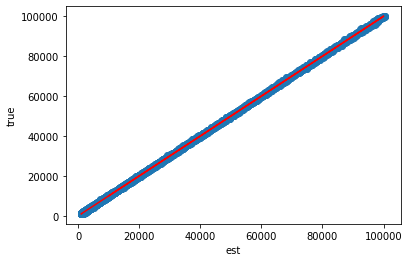

In [16]:
plt.scatter(est.detach().cpu(), 
            truth.cpu())

# x = y line
plt.plot(truth.cpu(), truth.cpu(), color = 'red')

plt.xlabel('est')
plt.ylabel('true')

### Plot some residuals

In [17]:
exp_flux = False

In [18]:
def reconstruct_image(flux): 
    return star_data.psf * flux + star_data.background

In [19]:
star_data.psf.shape

torch.Size([11, 11])

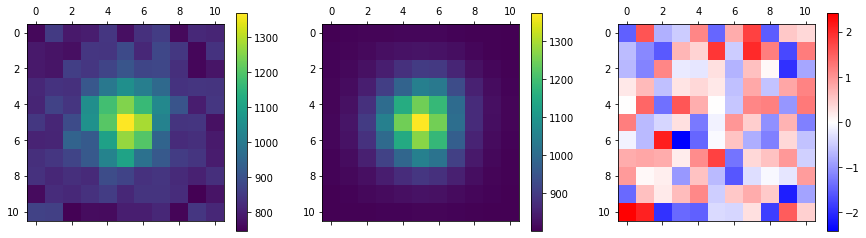

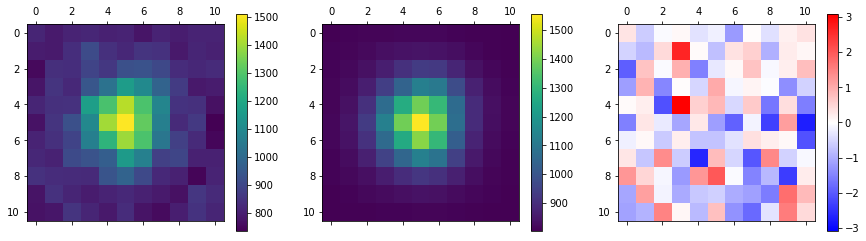

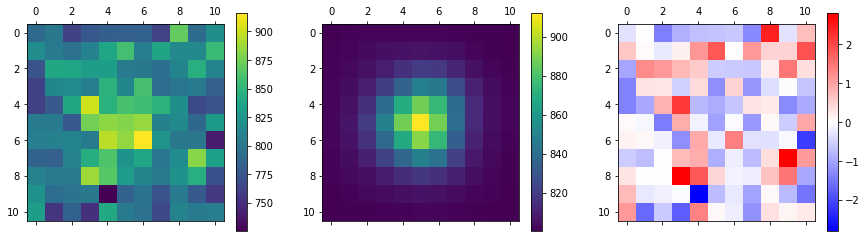

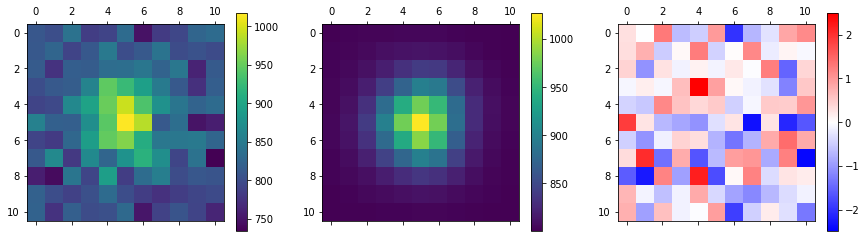

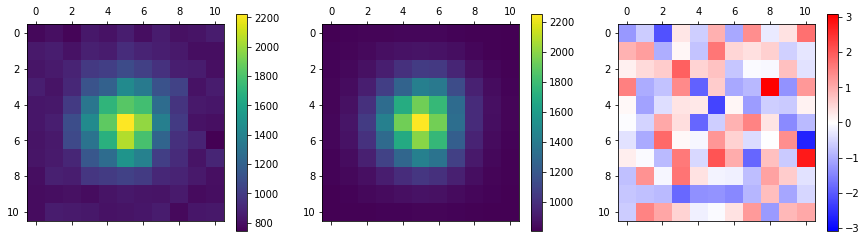

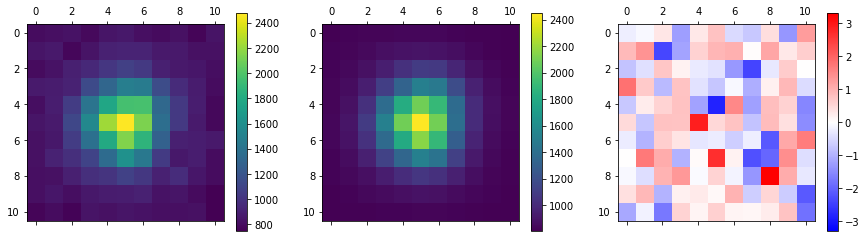

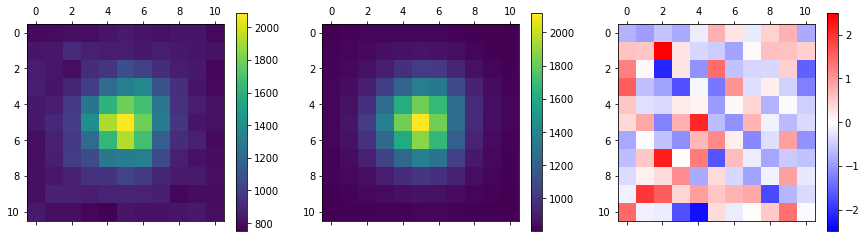

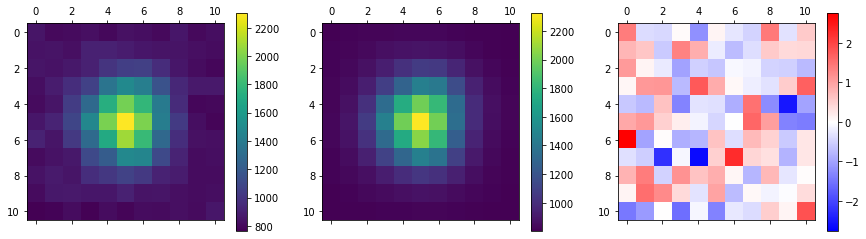

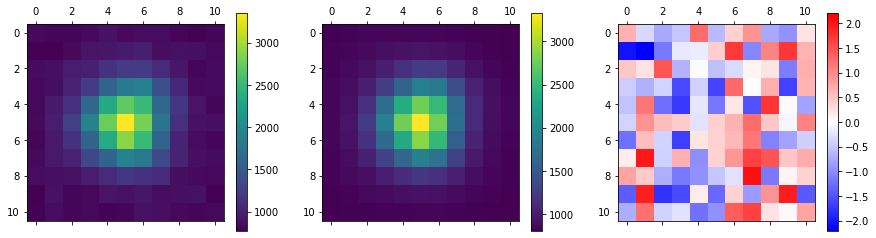

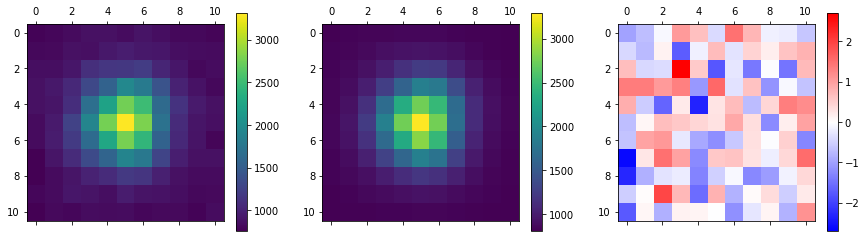

In [20]:
for i in range(10): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    image = test_batch['image'][i, 0].cpu()
    
    true_flux = truth[i]
    est_flux = est[i].detach().cpu()
    
    if exp_flux: 
        est_flux = est_flux.exp()
        true_flux = truth.exp()
    
    # plot true image    
    im = ax[0].matshow(image)
    fig.colorbar(im, ax = ax[0])

    # plot reconstructed image 
    recon = reconstruct_image(est_flux).cpu()
    im1 = ax[1].matshow(recon)
    fig.colorbar(im1, ax = ax[1])
    
    # plt residual 
    resid = (image - recon) / torch.sqrt(recon)
    vmax = resid.abs().max()
    im2 = ax[2].matshow(resid, 
                        vmax = vmax, 
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im2, ax = ax[2])

# Check SDs

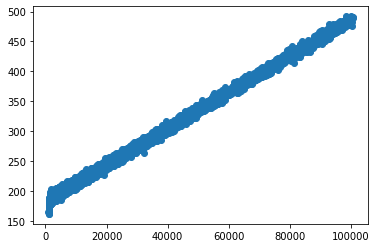

In [22]:
plt.scatter(est.detach().cpu().numpy(), 
            sd.detach().cpu().numpy())

In [38]:
from scipy import stats

In [39]:
zscore = ((est - truth) / sd).detach().cpu().numpy()

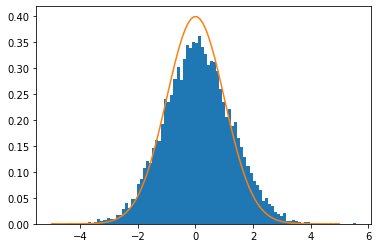

In [40]:
plt.hist(zscore, bins = 100, density = True);
x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.pdf(x))